# Initialising Libraries 

In [282]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Retrieving fiscal dates

In [285]:
def get_last_n_fiscal_year_dates(symbol, start_year, count):
    stock = yf.Ticker(symbol)

    # Fetch the balance sheet and income statement
    balance_sheet = stock.balance_sheet
    income_statement = stock.financials

    # Get the dates (column names) from the balance sheet and income statement
    balance_sheet_dates = balance_sheet.columns.tolist()
    income_statement_dates = income_statement.columns.tolist()

    # Generate the list of years to retrieve
    years_to_fetch = [str(start_year - i) for i in range(count)]

    # Prepare lists to store matching dates
    matching_balance_sheet_dates = []
    matching_income_statement_dates = []

    # Loop through the years to find matching fiscal year-end dates
    for year in years_to_fetch:
        year_start = f"{year}-01-01"
        year_end = f"{year}-12-31"

        # Find matching dates in balance sheet
        for date in balance_sheet_dates:
            if year_start <= str(date.date()) <= year_end:
                matching_balance_sheet_dates.append(date)

        # Find matching dates in income statement
        for date in income_statement_dates:
            if year_start <= str(date.date()) <= year_end:
                matching_income_statement_dates.append(date)

    # Get the last 'count' matching dates from both financials
    balance_sheet_dates_last = matching_balance_sheet_dates[-count:]
    income_statement_dates_last = matching_income_statement_dates[-count:]

    return balance_sheet_dates_last, income_statement_dates_last


# Retrieving financial data

In [288]:
def get_financial_data(symbol, fiscal_dates):
    stock = yf.Ticker(symbol)

    # Fetch the balance sheet and income statement
    balance_sheet = stock.balance_sheet
    income_statement = stock.financials

    # Prepare to store the relevant data
    balance_sheet_data = {}
    income_statement_data = {}

    for date in fiscal_dates:
        if date in balance_sheet.columns:
            balance_sheet_data[date] = balance_sheet[date]
        if date in income_statement.columns:
            income_statement_data[date] = income_statement[date]

    return balance_sheet_data, income_statement_data


# Calculating Ratios 

In [291]:
# Function to calculate the current ratio
def calculate_current_ratio(balance_sheet):
    balance_sheet_df = pd.DataFrame(balance_sheet).T
    current_assets = balance_sheet_df.get('Current Assets', pd.Series([0]))
    current_liabilities = balance_sheet_df.get('Current Liabilities', pd.Series([0]))
    current_assets_value = current_assets.item() if not current_assets.empty else 0
    current_liabilities_value = current_liabilities.item() if not current_liabilities.empty else 0
    return current_assets_value / current_liabilities_value if current_liabilities_value != 0 else 0

# Function to calculate the gross profit ratio
def calculate_gross_profit_ratio(income_statement):
    gross_profit = income_statement.get('Gross Profit', 0)
    total_revenue = income_statement.get('Total Revenue', 0)
    return gross_profit / total_revenue if total_revenue != 0 else 0

# Function to calculate the return on investment
def calculate_return_on_investment(balance_sheet, income_statement):
    equity = balance_sheet.get('Stockholders Equity', 0)
    long_term_debt = balance_sheet.get('Long Term Debt', 0)
    investments = equity + long_term_debt
    net_income = income_statement.get('Net Income', 0)
    return net_income / investments if investments != 0 else 0


# Calculating ratios for multiple companies

In [293]:
# Function to calculate ratios for multiple companies
def calculate_ratios_for_companies(companies, start_year, count, ratios):
    results_list = []  # Create a list to hold results
    for company in companies:
        balance_sheets, income_statements = get_financial_data(company, get_last_n_fiscal_year_dates(company, start_year, count)[0])
        for fiscal_year in balance_sheets.keys():
            balance_sheet = balance_sheets[fiscal_year]
            income_statement = income_statements.get(fiscal_year, {})
            ratio_values = {'Company': company, 'Fiscal Year': fiscal_year}

            for ratio in ratios:
                if ratio == "current_ratio":
                    ratio_values['current_ratio'] = calculate_current_ratio(balance_sheet)
                elif ratio == "gross_profit_ratio":
                    ratio_values['gross_profit_ratio'] = calculate_gross_profit_ratio(income_statement)
                elif ratio == "return_on_investment":
                    ratio_values['return_on_investment'] = calculate_return_on_investment(balance_sheet, income_statement)
                else:
                    print(f"Invalid ratio type: {ratio}")

            results_list.append(ratio_values)  # Append the dictionary to the list

    return pd.DataFrame(results_list)  # Create DataFrame from the list of dictionaries


# Comapring With Industry Standards

In [297]:
def compare_with_industry(results_df, industry_standards):
    # Iterate over each row in the DataFrame and compare with industry standards
    for idx, row in results_df.iterrows():
        company = row['Company']
        fiscal_year = row['Fiscal Year']

        # Check each ratio against the industry standard
        for ratio in industry_standards.keys():
            company_ratio = row[ratio]
            industry_value = industry_standards[ratio]
            comparison = "above" if company_ratio > industry_value else "below"
            print(f"{company} in {fiscal_year}: {ratio} is {comparison} industry standard (Company: {company_ratio}, Industry: {industry_value}).")

# Plotting

In [300]:
# Plotting function (provided earlier)
def plot_ratios(results_df):
    ratios = ['current_ratio', 'gross_profit_ratio', 'return_on_investment']
    for ratio in ratios:
        plt.figure(figsize=(10, 5))
        for company in results_df['Company'].unique():
            company_data = results_df[results_df['Company'] == company]
            plt.plot(company_data['Fiscal Year'], company_data[ratio], marker='o', label=company)

        plt.title(f'{ratio.replace("_", " ").title()} Comparison')
        plt.xlabel('Fiscal Year')
        plt.ylabel(ratio.replace("_", " ").title())
        plt.xticks(rotation=45)  # Rotate x labels for better readability
        plt.legend()
        plt.grid()
        plt.tight_layout()  # Adjust layout
        plt.show()

# Main Execution Block 

Enter the industry standard for Current Ratio (e.g., 1.5):  1.5
Enter the industry standard for Gross Profit Ratio (e.g., 0.4):  0.4
Enter the industry standard for Return on Investment (e.g., 0.1):  0.1
Enter the starting fiscal year (e.g., 2023):  2023
Enter the number of years to retrieve:  5
Enter the company tickers separated by commas (e.g., AAPL, GOOGL):  AAPL, GOOGL


  Company Fiscal Year  current_ratio  gross_profit_ratio  return_on_investment
0    AAPL  2023-09-30       0.988012            0.441311              0.616127
1    AAPL  2022-09-30       0.879356            0.433096              0.666994
2    AAPL  2021-09-30       1.074553            0.417794              0.549839
3    AAPL  2020-09-30            NaN                 NaN                   NaN
4   GOOGL  2023-12-31       2.096585            0.566250              0.249942
5   GOOGL  2022-12-31       2.377994            0.553794              0.222943
6   GOOGL  2021-12-31       2.928113            0.569398              0.287482
7   GOOGL  2020-12-31       3.066756            0.535784              0.171084
8   GOOGL  2019-12-31            NaN                 NaN                   NaN


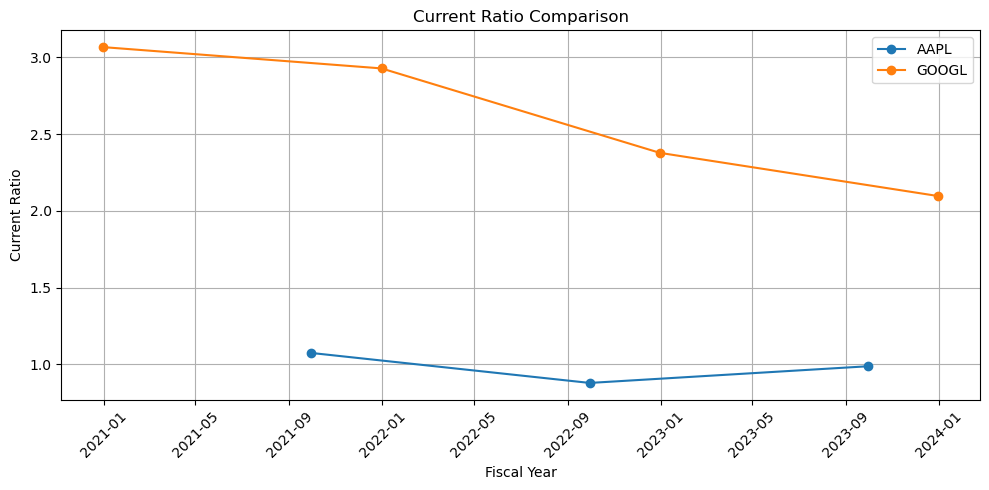

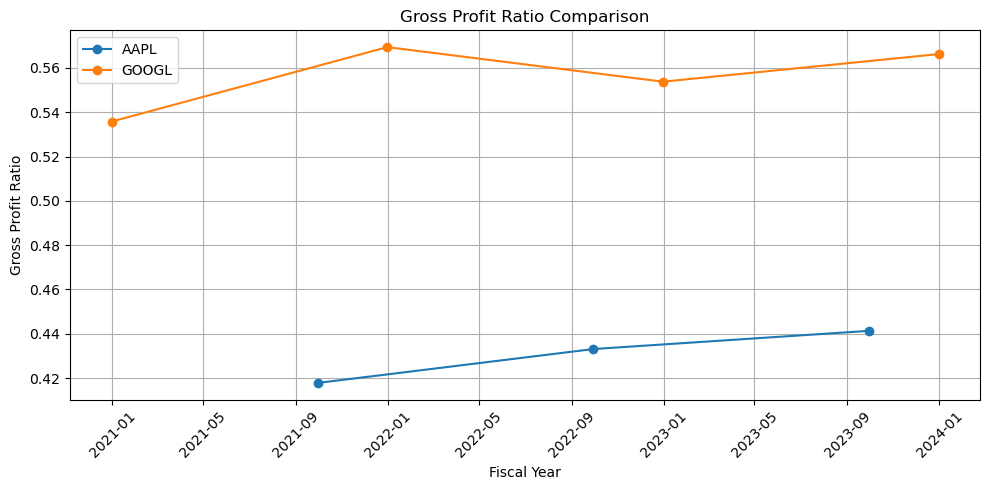

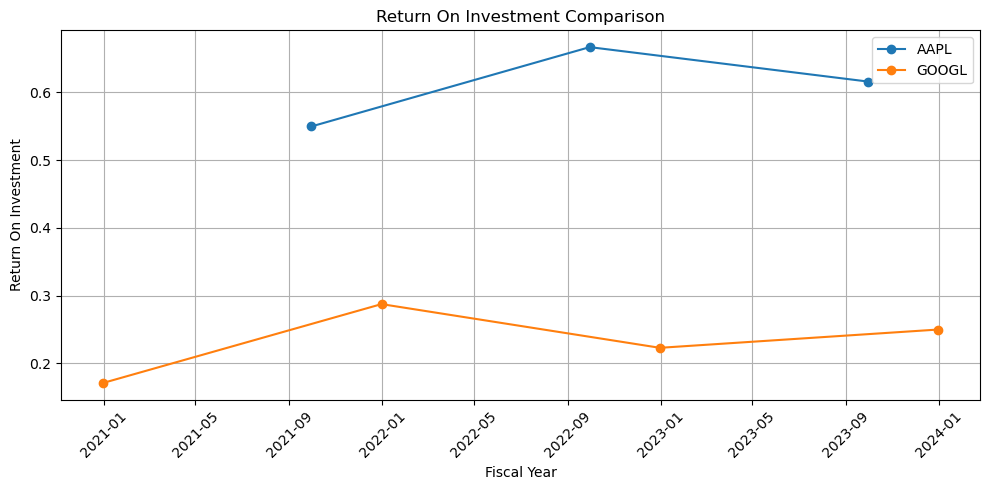

AAPL in 2023-09-30 00:00:00: current_ratio is below industry standard (Company: 0.9880116717592975, Industry: 1.5).
AAPL in 2023-09-30 00:00:00: gross_profit_ratio is above industry standard (Company: 0.4413112957720756, Industry: 0.4).
AAPL in 2023-09-30 00:00:00: return_on_investment is above industry standard (Company: 0.6161268397415945, Industry: 0.1).
AAPL in 2022-09-30 00:00:00: current_ratio is below industry standard (Company: 0.8793560286267226, Industry: 1.5).
AAPL in 2022-09-30 00:00:00: gross_profit_ratio is above industry standard (Company: 0.43309630561360085, Industry: 0.4).
AAPL in 2022-09-30 00:00:00: return_on_investment is above industry standard (Company: 0.6669941389150644, Industry: 0.1).
AAPL in 2021-09-30 00:00:00: current_ratio is below industry standard (Company: 1.0745531195957954, Industry: 1.5).
AAPL in 2021-09-30 00:00:00: gross_profit_ratio is above industry standard (Company: 0.4177935962516778, Industry: 0.4).
AAPL in 2021-09-30 00:00:00: return_on_inv

In [303]:
# Main execution
try:
    # Get industry standards from the user
    industry_standards = {}
    industry_standards["current_ratio"] = float(input("Enter the industry standard for Current Ratio (e.g., 1.5): "))
    industry_standards["gross_profit_ratio"] = float(input("Enter the industry standard for Gross Profit Ratio (e.g., 0.4): "))
    industry_standards["return_on_investment"] = float(input("Enter the industry standard for Return on Investment (e.g., 0.1): "))

    # Get other inputs from the user
    input_year = int(input("Enter the starting fiscal year (e.g., 2023): "))
    number_of_years = int(input("Enter the number of years to retrieve: "))
    
    companies_input = input("Enter the company tickers separated by commas (e.g., AAPL, GOOGL): ")
    companies = [ticker.strip().upper() for ticker in companies_input.split(",")]

    ratios = ['current_ratio', 'gross_profit_ratio', 'return_on_investment']
    
    # Calculate ratios and store in DataFrame
    ratios_results_df = calculate_ratios_for_companies(companies, input_year, number_of_years, ratios)

    # Print results for each company
    print(ratios_results_df)

    # Plot the ratios
    plot_ratios(ratios_results_df)

    # Compare with industry standards
    compare_with_industry(ratios_results_df, industry_standards)

except ValueError:
    print("Please enter a valid input.")
